In [ ]:
#Importy
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
import scipy.signal as ss
from  scipy.signal import freqz, group_delay #funkcja obliczająca funkcję systemu
from  scipy.signal import firwin, firwin2     # funkcje do projektowania filtrów FIR
from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import cheby1, cheb1ord    # funkcje do projektowania filtrów 
from  scipy.signal import cheby2, cheb2ord    # funkcje do projektowania filtrów 
from  scipy.signal import ellip, ellipord     # funkcje do projektowania filtrów eliptycznych
from  scipy.signal import iirnotch
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów
from  scipy.signal import butter

In [ ]:
def charkterystyki(a,b,f,T,Fs, f_lim = None):
    if f_lim == None:
      f_lim = (0, Fs/2)
    # przyda nam się oś czasu od -T do T sekund
    t = np.arange(-T, T, 1/Fs)
  
    # obliczamy transmitancję; chcemy worN = f
    f, h = freqz(b,a,f,fs = Fs) 
    
    # obliczamy moduł transmitancji
    m = np.abs(h)
        
    # obliczamy fazę i "rozwijamy" ją   
    faza = np.unwrap(np.angle(h))
    w = 2*np.pi*f/Fs 
  
    # obliczamy opóźnienie grupowe
    ff, grupowe = group_delay((b, a), f,fs=Fs)
    
    # obliczamy odpowiedź impulsową
    x = np.zeros(len(t))
    x[len(t)//2] = 1 # impuls
    y = lfilter(b,a,x) # przepuszczamy impuls przez filtr i obserwujemy odpowiedź impulsową
    
    # obliczamy odpowiedź schodkową
    s = np.zeros(len(t))
    s[len(t)//2:] = 1 # schodek
    ys = lfilter(b,a,s) # przepuszczamy schodek przez filtr i obserwujemy odpowiedź schodkową
    
    # rysujemy
    fig = plt.figure()
    plt.subplot(2,2,1)
    plt.title('moduł transmitancji')
    M = 20*np.log10(m)
    plt.plot(f,M)
    plt.ylabel('[dB]')
    plt.grid('on')
    plt.xlim(f_lim)
    M_zoom = M[np.logical_and( f_lim[0]<f , f<f_lim[1])]
    plt.ylim((np.min(M_zoom), np.max(M_zoom)))
    
    plt.subplot(2,2,3)
    plt.title('opóźnienie grupowe')
    plt.plot(f,grupowe)
    plt.ylabel('probki')
    plt.xlabel('Częstość [Hz]')
    plt.grid('on')
    plt.xlim(f_lim)
    plt.ylim([np.min(grupowe)-1, np.max(grupowe)+1])
    
    plt.subplot(2,2,2)
    plt.title('odpowiedź impulsowa')
    plt.plot(t, x)
    plt.plot(t, y)
    plt.xlim([-T/4,T])
    plt.grid('on')
    
    plt.subplot(2,2,4)
    plt.title('odpowiedź schodkowa')
    plt.plot(t, s)
    plt.plot(t, ys)
    plt.xlim([-T/4,T])
    plt.xlabel('Czas [s]')
    plt.grid('on')
    
    fig.subplots_adjust(hspace=.5)
    plt.show()

In [ ]:
#Ustawiam domyślne wielkości wykresów
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

#Wczytuję pliki
ds = np.DataSource(None)
gfile = ds.open('Franek_RS.raw','rb')
s = np.fromfile(gfile, dtype='<f')

gfile = ds.open('Franek_WF.raw','rb')
sWF = np.fromfile(gfile, dtype='<f')

s *= 0.0715
sWF *= 0.0715

n_ch = 3
syg = np.reshape(s,(len(s)//n_ch,n_ch))
sygWF = np.reshape(sWF,(len(sWF)//n_ch,n_ch))

Fs = 128
T = len(syg)/Fs
dt = 1/Fs
t = np.arange(0,T,dt)

f = np.arange(0.01,Fs/2,0.01)

TWF = len(sygWF)/Fs
tWF = np.arange(0,TWF,dt)


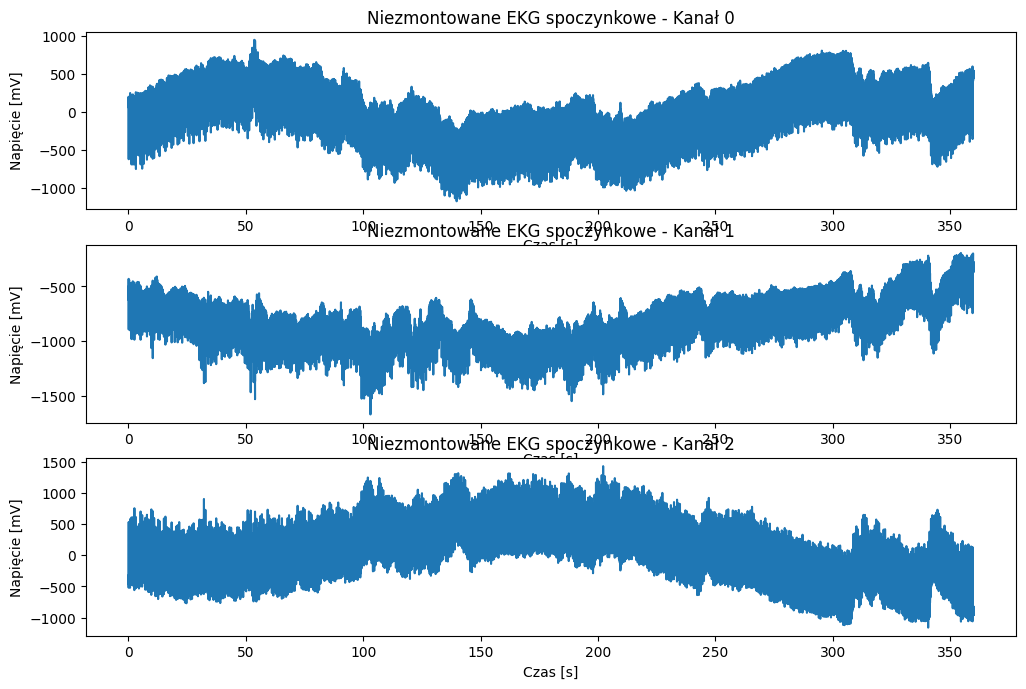

In [ ]:
plt.figure()
for ch in range(n_ch):
    plt.subplot(n_ch,1,ch+1)
    plt.plot(t, syg[0:len(syg),ch])
    plt.xlabel('Czas [s]')
    plt.ylabel('Napięcie [uV]')
    plt.title('Niezmontowane EKG spoczynkowe - Kanał '+str(ch))
plt.show()

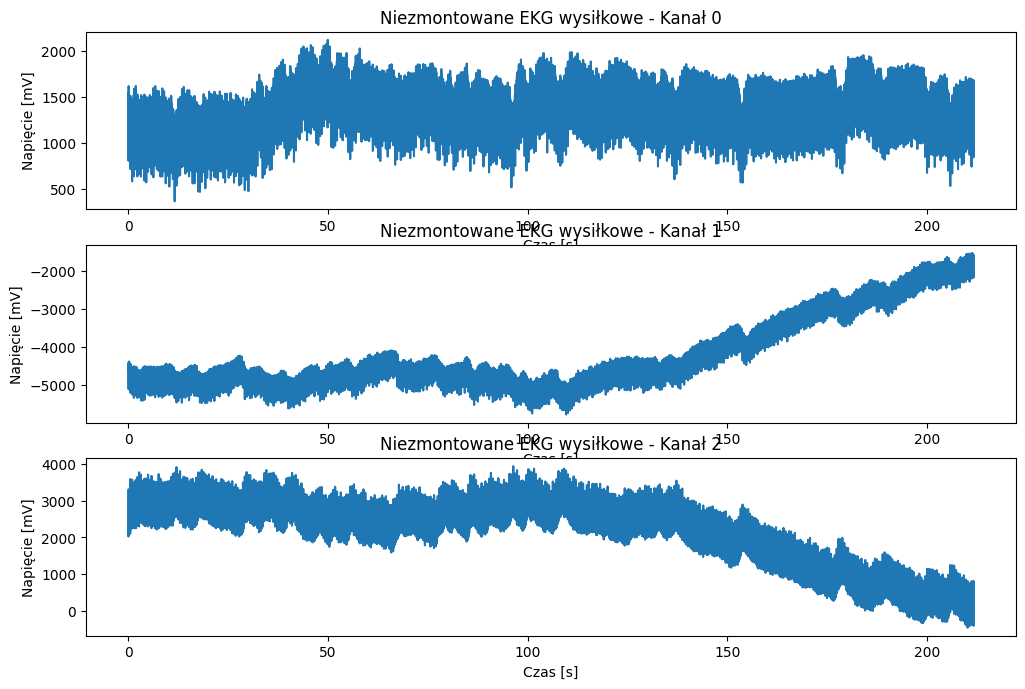

In [ ]:
plt.figure()
for ch in range(n_ch):
    plt.subplot(n_ch,1,ch+1)
    plt.plot(tWF, sygWF[0:len(syg),ch])
    plt.xlabel('Czas [s]')
    plt.ylabel('Napięcie [uV]')
    plt.title('Niezmontowane EKG wysiłkowe - Kanał '+str(ch))
plt.show()

**Montaż Einthovena i porównanie filtrowanych sygnałów**

In [ ]:
#Montaż Einthovena
ch1 = syg[0:len(syg),0] - syg[0:len(syg),1]
ch2 = syg[0:len(syg),2] - syg[0:len(syg),0]
ch3 = syg[0:len(syg),2] - syg[0:len(syg),1]

ch1W = sygWF[0:len(sygWF),0] - sygWF[0:len(sygWF),1]
ch2W = sygWF[0:len(sygWF),2] - sygWF[0:len(sygWF),0]
ch3W = sygWF[0:len(sygWF),2] - sygWF[0:len(sygWF),1]

**Analiza własności poszczególnych filtrów testowane na sygnale spoczynkowym**

In [ ]:
f = np.arange(0.01,Fs/2,0.01)

[b_ch1,a_ch1]=butter(1,0.6,fs=Fs,btype='highpass' )
charkterystyki(a_ch1,b_ch1,f,T,Fs)
print('Filtr Butterwortha, rząd:', 1)

sf_ch1_1 = filtfilt(b_ch1, a_ch1, ch1)
plt.plot(sf_ch1_1[400:700])
plt.show()

In [ ]:
[b2_ch1,a2_ch1]=butter(2,40,fs=Fs,btype='lowpass')
charkterystyki(a2_ch1,b2_ch1,f,T,Fs)
print('Filtr Butterwortha, rząd:', 2)

sf_ch1_2 = filtfilt(b2_ch1, a2_ch1, ch1)
plt.plot(sf_ch1_2[400:700])
plt.show()

In [ ]:
[b3_ch1,a3_ch1] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
charkterystyki(a3_ch1,b3_ch1,f,T,Fs)
print('Filtr Chebysheva 2 Rodzaju, rząd:', 2)

sf_ch1_3 = filtfilt(b3_ch1, a3_ch1, ch1)
plt.plot(sf_ch1_3[400:700])
plt.show()

Text(0, 0.5, 'Napięcie [mV]')

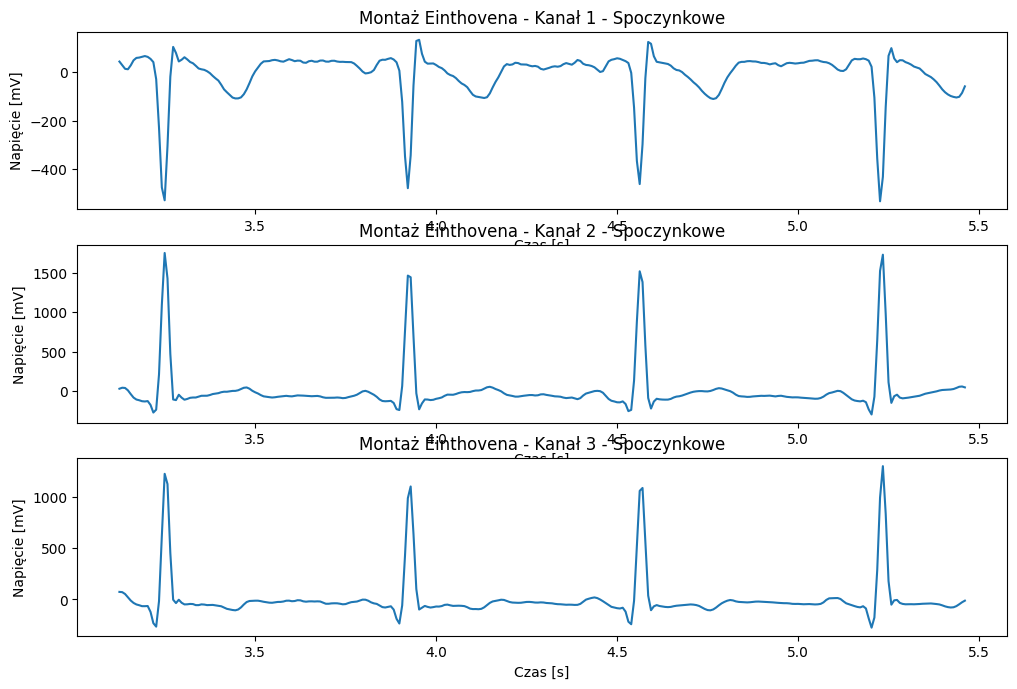

In [ ]:
filtered_channels = []
for channel in [ch1,ch2,ch3]:
  [b1,a1]=butter(1,0.6,fs=Fs,btype='highpass')
  sf1 = filtfilt(b1, a1, channel)
  [b2,a2]=butter(2,40,fs=Fs,btype='lowpass')
  sf2 = filtfilt(b2, a2, sf1)
  [b3,a3] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
  sf3 = filtfilt(b3, a3, sf2)
  filtered_channels.append(sf3)

plt.subplot(3,1,1)
plt.plot(t[400:700],filtered_channels[0][400:700])
plt.title('Montaż Einthovena - Kanał 1 - Spoczynkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(t[400:700],filtered_channels[1][400:700])
plt.title('Montaż Einthovena - Kanał 2 - Spoczynkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(t[400:700],filtered_channels[2][400:700])
plt.title('Montaż Einthovena - Kanał 3 - Spoczynkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')



Text(0, 0.5, 'Napięcie [mV]')

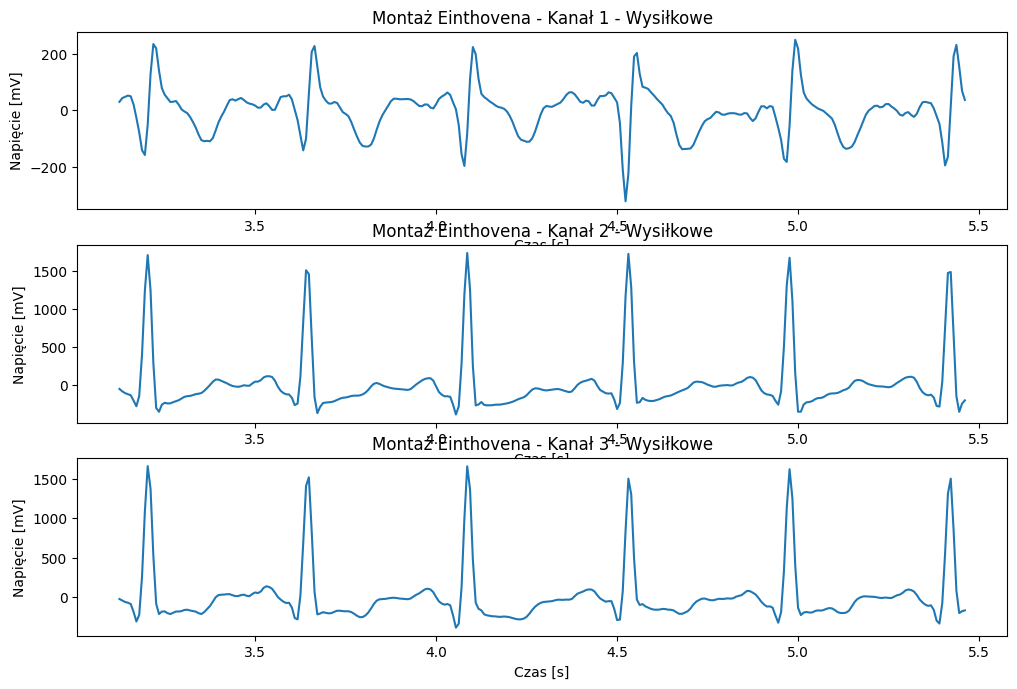

In [ ]:
filtered_channels = []
for channel in [ch1W,ch2W,ch3W]:
  [b1,a1]=butter(1,0.6,fs=Fs,btype='highpass')
  sf1 = filtfilt(b1, a1, channel)
  [b2,a2]=butter(2,40,fs=Fs,btype='lowpass')
  sf2 = filtfilt(b2, a2, sf1)
  [b3,a3] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
  sf3 = filtfilt(b3, a3, sf2)
  filtered_channels.append(sf3)

plt.subplot(3,1,1)
plt.plot(tWF[400:700],filtered_channels[0][400:700])
plt.title('Montaż Einthovena - Kanał 1 - Wysiłkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(tWF[400:700],filtered_channels[1][400:700])
plt.title('Montaż Einthovena - Kanał 2 - Wysiłkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(tWF[400:700],filtered_channels[2][400:700])
plt.title('Montaż Einthovena - Kanał 3 - Wysiłkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

**Montaż Goldberga i porównanie filtrowanych sygnałów**

In [ ]:
#Montaż Goldberga
ch1 = syg[0:len(syg),0] - 0.5*syg[0:len(syg),1] - 0.5*syg[0:len(syg),2]
ch2 = syg[0:len(syg),1] - 0.5*syg[0:len(syg),0] - 0.5*syg[0:len(syg),2]
ch3 = syg[0:len(syg),2] - 0.5*syg[0:len(syg),0] - 0.5*syg[0:len(syg),1]

ch1W = sygWF[0:len(sygWF),0] - 0.5*sygWF[0:len(sygWF),1] - 0.5*sygWF[0:len(sygWF),2]
ch2W = sygWF[0:len(sygWF),1] - 0.5*sygWF[0:len(sygWF),0] - 0.5*sygWF[0:len(sygWF),2]
ch3W = sygWF[0:len(sygWF),2] - 0.5*sygWF[0:len(sygWF),0] - 0.5*sygWF[0:len(sygWF),1]

Text(0, 0.5, 'Napięcie [mV]')

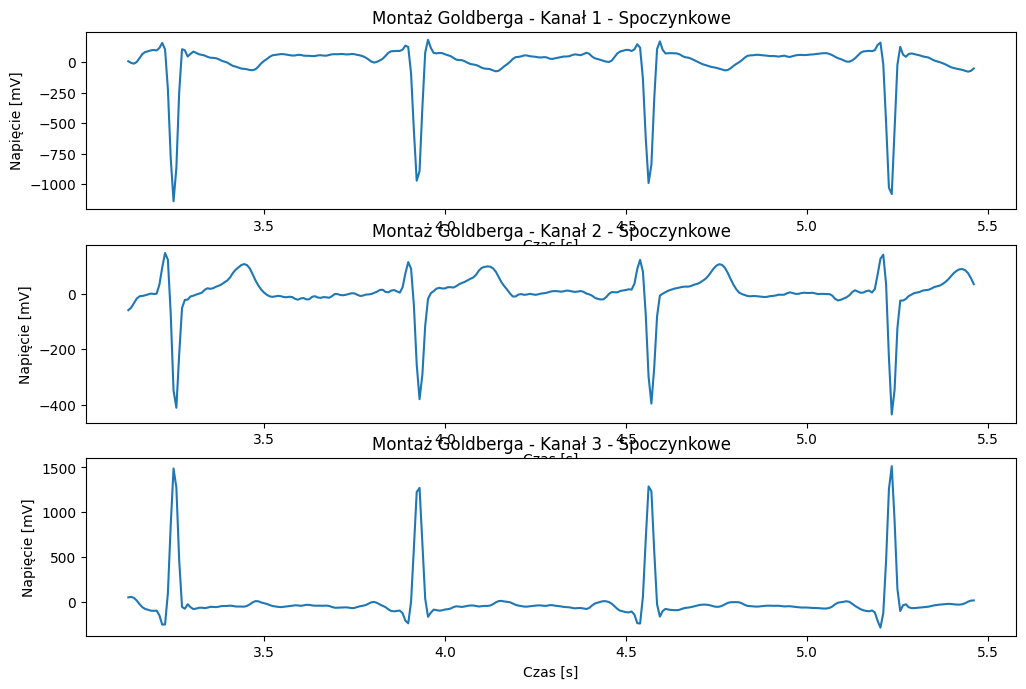

In [ ]:
filtered_channels = []
for channel in [ch1,ch2,ch3]:
  [b1,a1]=butter(1,0.6,fs=Fs,btype='highpass')
  sf1 = filtfilt(b1, a1, channel)
  [b2,a2]=butter(2,40,fs=Fs,btype='lowpass')
  sf2 = filtfilt(b2, a2, sf1)
  [b3,a3] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
  sf3 = filtfilt(b3, a3, sf2)
  filtered_channels.append(sf3)

plt.subplot(3,1,1)
plt.plot(t[400:700],filtered_channels[0][400:700])
plt.title('Montaż Goldberga - Kanał 1 - Spoczynkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(t[400:700],filtered_channels[1][400:700])
plt.title('Montaż Goldberga - Kanał 2 - Spoczynkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(t[400:700],filtered_channels[2][400:700])
plt.title('Montaż Goldberga - Kanał 3 - Spoczynkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

Text(0, 0.5, 'Napięcie [mV]')

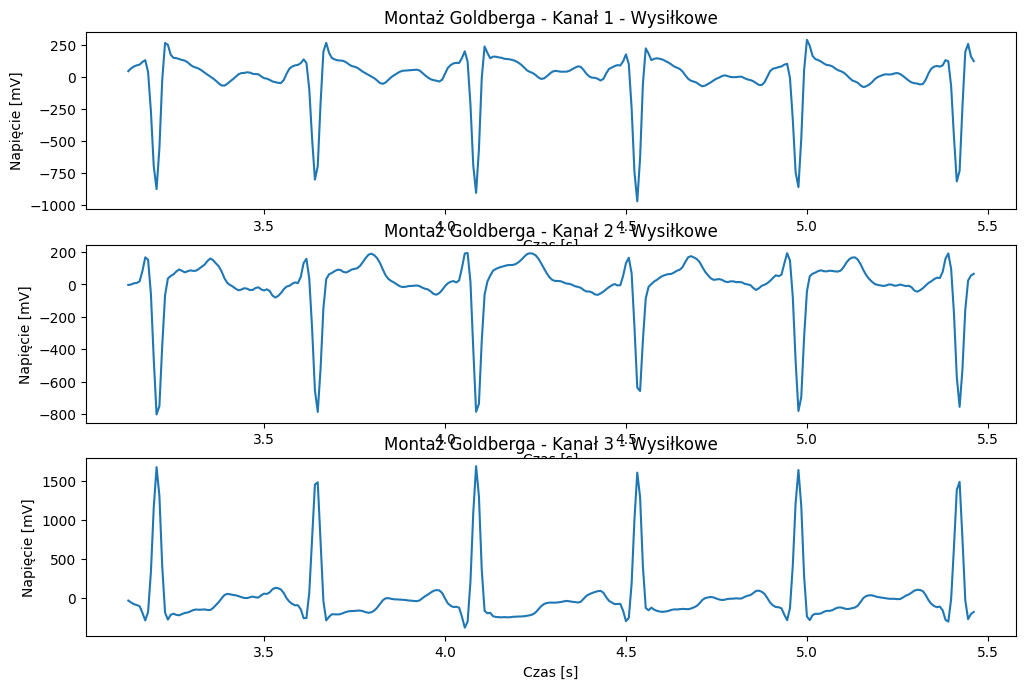

In [ ]:
filtered_channels = []
for channel in [ch1W,ch2W,ch3W]:
  [b1,a1]=butter(1,0.6,fs=Fs,btype='highpass')
  sf1 = filtfilt(b1, a1, channel)
  [b2,a2]=butter(2,40,fs=Fs,btype='lowpass')
  sf2 = filtfilt(b2, a2, sf1)
  [b3,a3] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
  sf3 = filtfilt(b3, a3, sf2)
  filtered_channels.append(sf3)

plt.subplot(3,1,1)
plt.plot(tWF[400:700],filtered_channels[0][400:700])
plt.title('Montaż Goldberga - Kanał 1 - Wysiłkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(tWF[400:700],filtered_channels[1][400:700])
plt.title('Montaż Goldberga - Kanał 2 - Wysiłkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(tWF[400:700],filtered_channels[2][400:700])
plt.title('Montaż Goldberga - Kanał 3 - Wysiłkowe')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

Dalsza praca na kanale 3 z sygnału wysiłkowego w montażu Goldberga

**Wyszukiwanie Pików**

In [ ]:
import more_itertools as mit

def FindSequence(l, n):
  l = list(l)
  indexes = [l.index(i) for i in l if i >= 300] #prog rozni sie dla montazy i kanalow ale lokalizacje pikow nie; można wyznaczać z histogramu
  r = [list(group) for group in mit.consecutive_groups(indexes)]
  result =  [group for group in r if len(group) >= n]
  return result

454


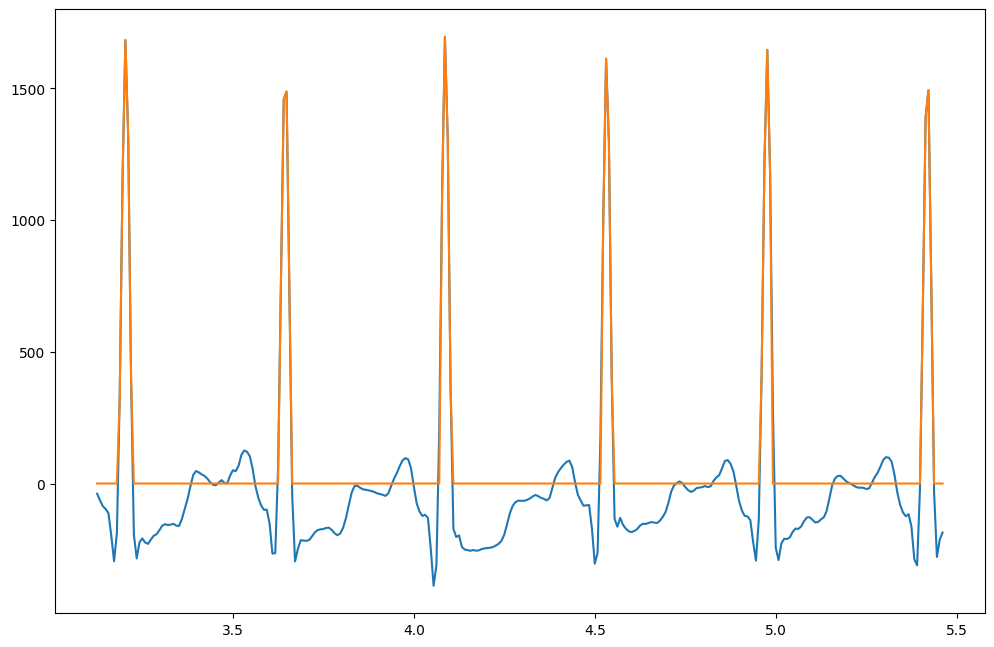

In [ ]:
#print(filtered_channels[2][400:450])
ind = FindSequence(filtered_channels[2], 3)#chyba gubi krótkie piki przy 4 - bylo tyle samo dziur tu co pikow w odleglosciach
print(len(ind))
sf = list(filtered_channels[2])
piki = np.zeros(len(filtered_channels[2]))
for seq in ind:
  for i in seq:
    piki[i] = sf[i]
plt.plot(tWF[400:700],filtered_channels[2][400:700])
plt.plot(tWF[400:700], piki[400:700])#[400:700]
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

In [ ]:
plt.plot(tWF[1400:1470],filtered_channels[2][1400:1470])
plt.plot(tWF[1400:1470], piki[1400:1470])#[400:700]
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
#print(filtered_channels[2][1400:1500])

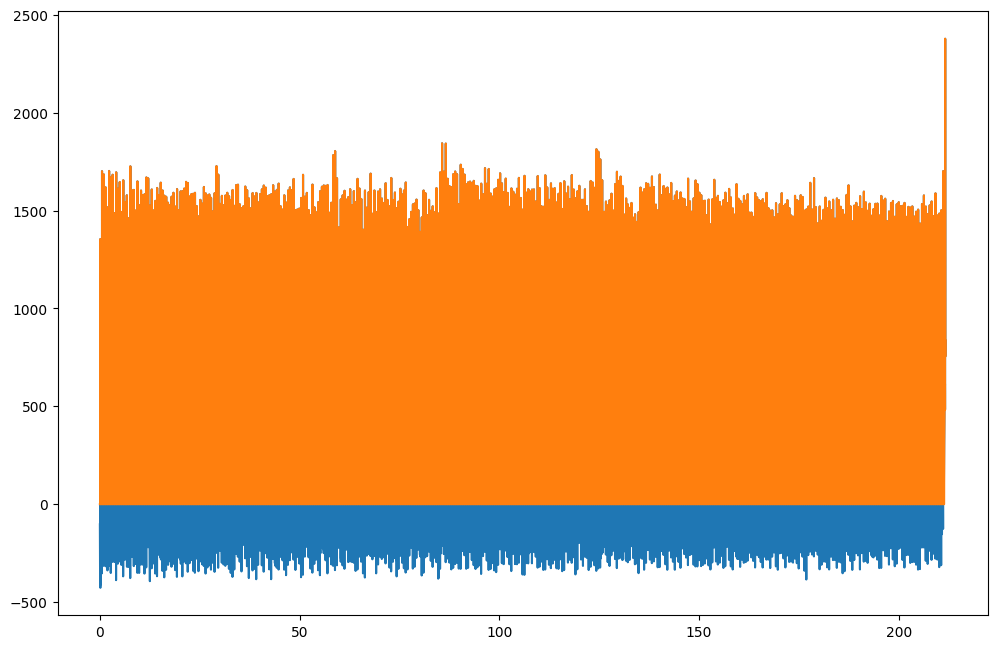

In [ ]:

plt.plot(tWF,filtered_channels[2])
plt.plot(tWF, piki)#[400:700]
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')


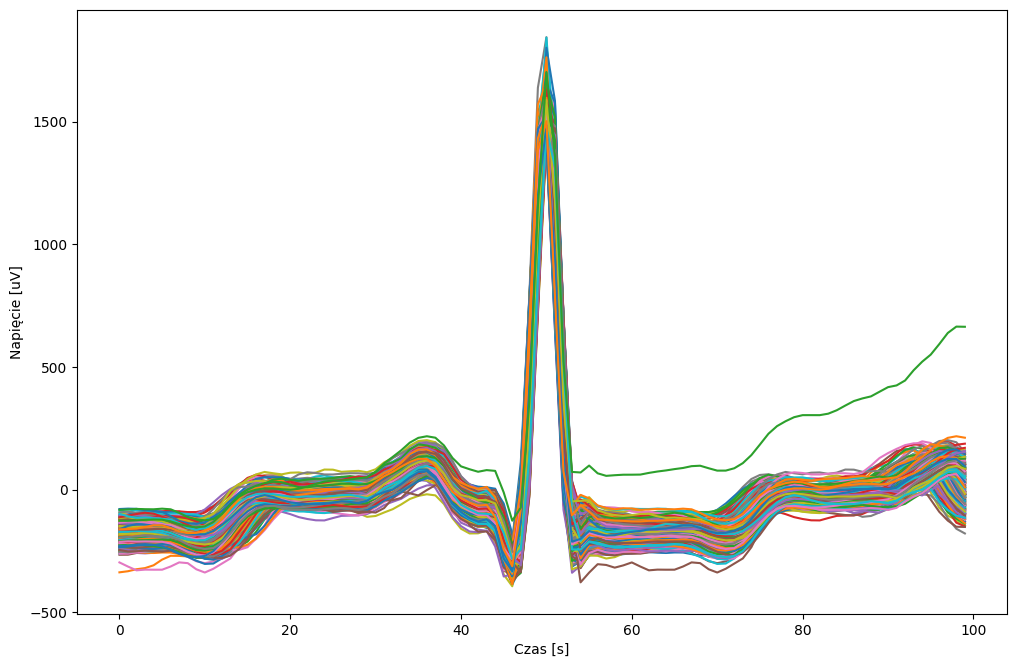

In [ ]:
#arbitralnie wyznaczam wycinki 
piki = list(piki)
lokalizacje_pików = [piki.index(i) for i in piki if i !=0]

grupy_pików = []
grupa = []
for i in range(0,len(lokalizacje_pików)-1):
  r = (lokalizacje_pików[i+1])-lokalizacje_pików[i]
  if r == 1:
    grupa.append(lokalizacje_pików[i])
  else:
    grupy_pików.append(grupa)
    grupa = []

wartosci_pikow = []
for g in grupy_pików:
  wartosci_pikow.append([(i, filtered_channels[2][i]) for i in g])

maksima = [max(g, key=lambda x: x[1])[0] for g in wartosci_pikow]

cykle = [list(filtered_channels[2][m-50:m+50]) for m in maksima]
#print(cykle)
for cykl in cykle:
  plt.plot(cykl)
  plt.xlabel('Czas [s]')
  plt.ylabel('Napięcie [uV]')


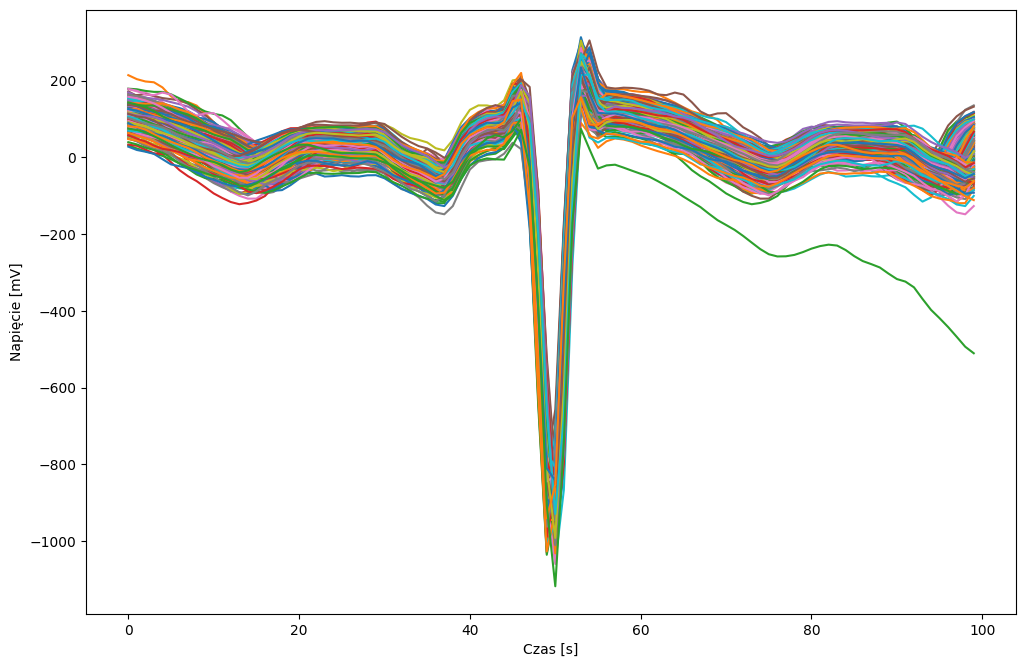

In [ ]:
#to jest nie tak bo maksima sie zmieniaja
cykle = [list(filtered_channels[0][m-50:m+50]) for m in maksima]
#print(cykle)
#print(len(cykle))
for cykl in cykle:
  plt.plot(cykl)
  plt.xlabel('Czas [s]')
  plt.ylabel('Napięcie [uV]')

**Wyznaczanie Tętna**

In [ ]:
T_minuty = TWF/60 
print('Tętno wysiłkowe: ', len(ind)/T_minuty)
#print(len(maksima)/T_minuty)#zrobic srednie tetno z tetn dla kazdej minuty
#porownaj z wynikami zdrowej populacji

Tętno wysiłkowe:  128.6992470101875


**Widmo Sygnału**

In [ ]:
def periodogram(s, okno , F_samp):
    '''peiodogram sygnału s
    okno - synał będzie przez nie przemnożony w czasie
    F_samp- częstość próbkowania'''
    s = s*okno
    N_fft = len(s)
    S = np.fft.rfft(s,N_fft)
    P = S*S.conj()/np.sum(okno**2)   
    P = P.real/Fs # P i tak ma zerowe wartości urojone, ale trzeba ykonać konwersję typów
    F = np.fft.rfftfreq(N_fft, 1/F_samp)
    if len(s)%2 ==0: # dokładamy Napięcie z ujemnej części widma 
        P[1:-1] *=2
    else:
        P[1:] *=2
    return (F,P)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


<StemContainer object of 3 artists>

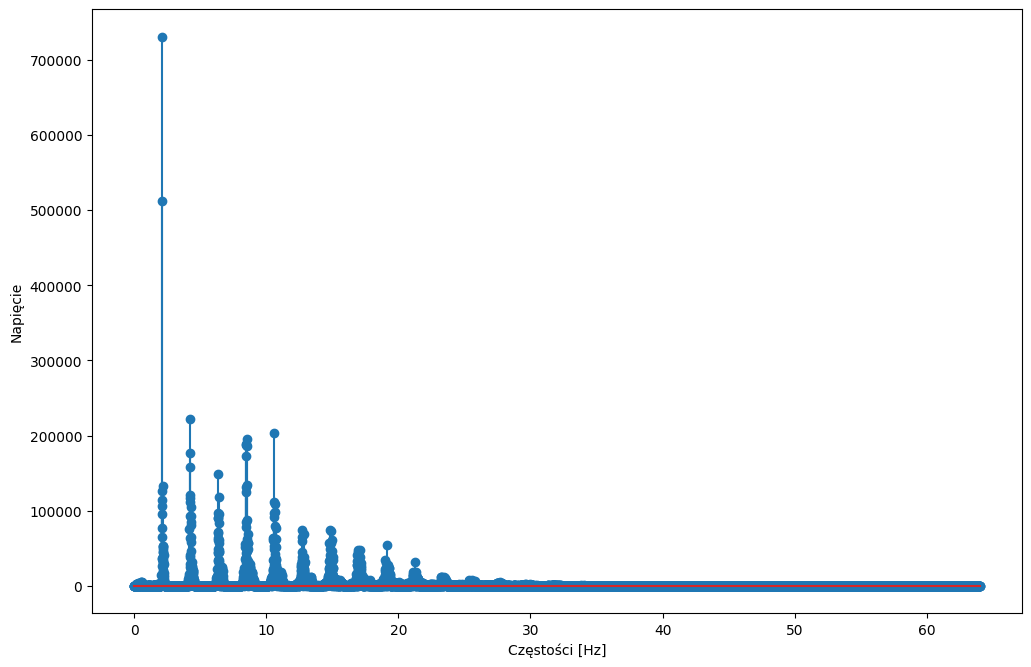

In [ ]:
okno = np.hamming(len(filtered_channels[0]))
F, P = periodogram(filtered_channels[0], okno, Fs)
plt.xlabel('Częstości [Hz]')
plt.ylabel('Moc')
plt.stem(F,P)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


<StemContainer object of 3 artists>

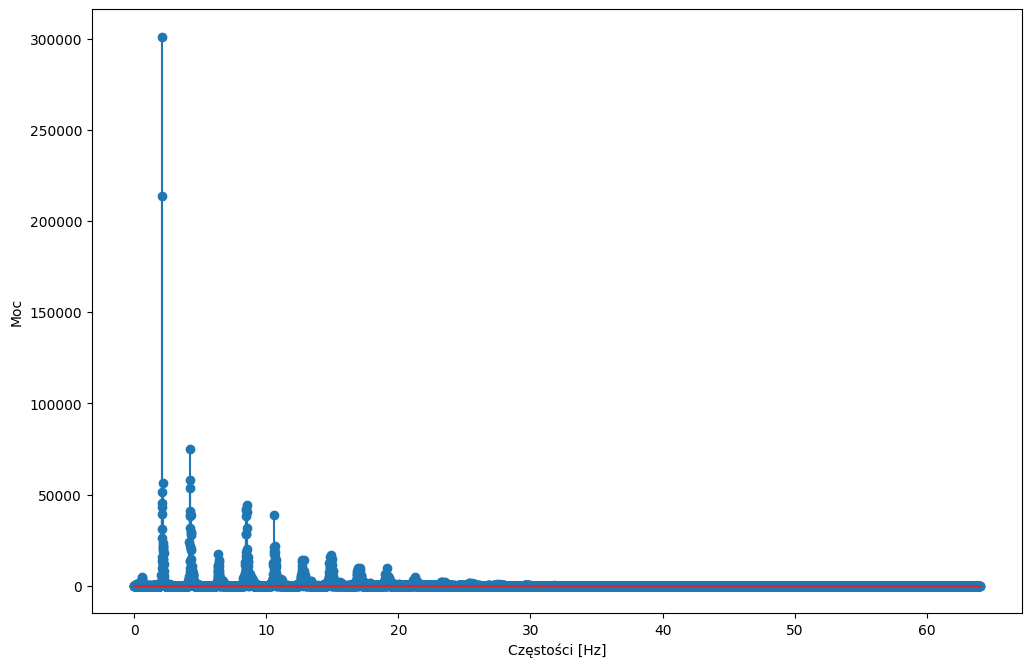

In [ ]:
okno = np.hamming(len(filtered_channels[1]))
F, P = periodogram(filtered_channels[1], okno, Fs)
plt.xlabel('Częstości [Hz]')
plt.ylabel('Moc')
plt.stem(F,P)

In [ ]:
okno = np.hamming(len(filtered_channels[2]))
F, P = periodogram(filtered_channels[2], okno, Fs)
plt.xlabel('Częstości [Hz]')
plt.ylabel('Moc')
plt.stem(F,P)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Napięcie')

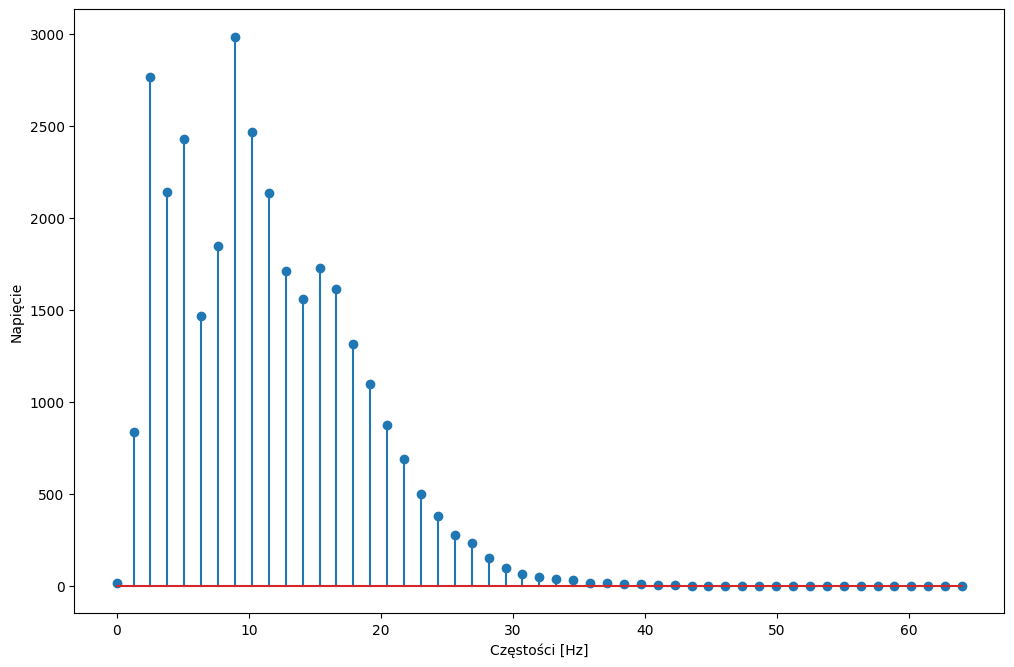

In [ ]:
okno = np.hamming(len(cykle[1]))
F, P = periodogram(cykle[1], okno, Fs)
plt.stem(F,P)
plt.xlabel('Częstości [Hz]')
plt.ylabel('Napięcie')

**Analiza HRV**

Text(0, 0.5, 'Interwały R-R')

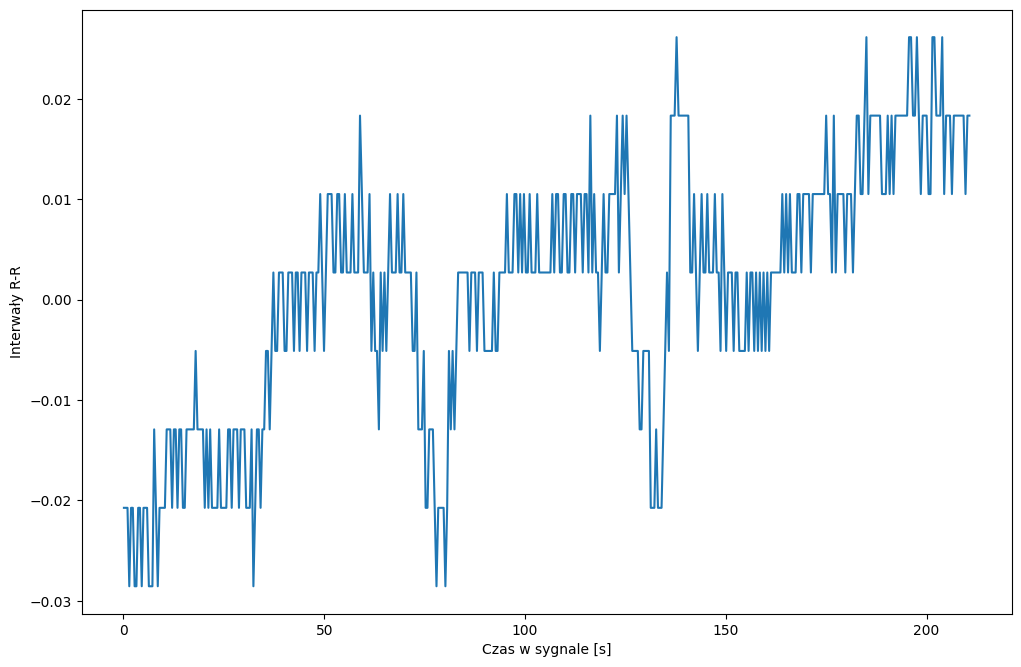

In [ ]:
odleglosci = []
czasy = []#odleglosci w czasie czy indeksach? jest roznica? CZASOWE
for p in range(len(lokalizacje_pików)-1): #moze zrob z maksimow nie lokpikow
  o = lokalizacje_pików[p+1]-lokalizacje_pików[p]
  if o !=1:
    odleglosci.append(o/Fs)
    czasy.append(tWF[lokalizacje_pików[p]])

#print(odleglosci)
odleglosci = odleglosci-np.mean(odleglosci)#po co się to robi - wyrysuj bez odjetej sredniej - usuwamy skladową stałą
tt = T/60
#print(len(odleglosci)/tt)
plt.plot(czasy[:len(czasy)-1],odleglosci[:len(odleglosci)-1])
plt.xlabel('Czas w sygnale [s]')
plt.ylabel('Interwały R-R')
#plt.plot(czasy,odleglosci)
#w widmie hrv spodziewamy sie 3 pikow

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


(0.0, 0.6)

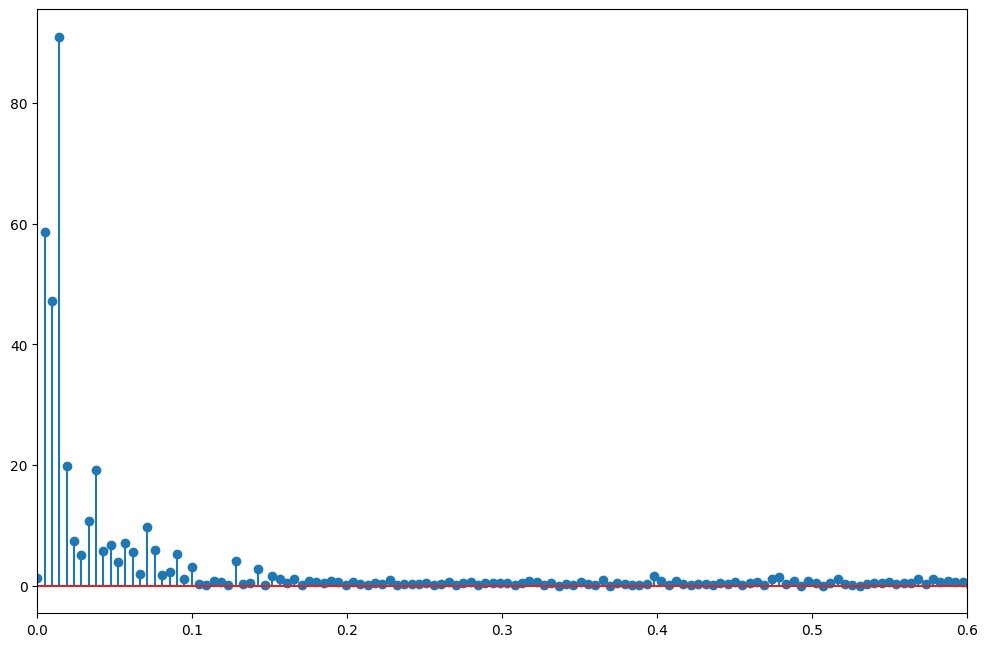

In [ ]:
funkcja = scipy.interpolate.interp1d(czasy,odleglosci)
xs = np.arange(czasy[0],czasy[-1],1/10)
hrv = funkcja(xs)
freqs = np.fft.rfftfreq(len(hrv),1/10)
plt.stem(freqs,np.abs(fft.rfft(hrv))**2)
plt.xlim((0,0.6))